In [1]:
import os
import math as mt
import numpy as np
import pandas as pd
import random as rd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from itertools import chain
from collections import Counter

In [2]:
%%time
def PermutationsCount(Length):
    return int(((Length-1)/2)*Length)

def Permutations(List):
    Combinations=[]
    for i in range(len(List)):
        for j in range(i+1,len(List)):
            Combinations.append( [List[i],List[j]] )
    return Combinations

def PreProcessing(Path):
    Labels = sorted(os.listdir(Path))

    with open('./People.txt','w') as File:
        for label in Labels:
            path = os.path.join(Path, label)
            images = os.listdir(path)
            File.write(','.join([label,str(len(images))+'\n' ]))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [3]:
%%time
Path="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"
#Path="/kaggle/input/humanfaces/lfw"
PreProcessing(Path)

CPU times: user 230 ms, sys: 440 ms, total: 670 ms
Wall time: 3.97 s


In [4]:
class DataLoader():
    def __init__(self,Path,transform):
        self.Transformations = transform
        self.Path=Path
        self.ImageCount=0
        self.SingleImageCount=0
        self.People2ID = []
        self.Dataset = torchvision.datasets.ImageFolder(root=Path,transform=self.Transformations)
        self.People=[]
        self.SinglePeople=[]
        self.Pairs=None
        self.AllCombinations={}
        self.AvgPairCount=0
        self.Train=None
        self.Test=None
        self.TestLabels=None
        self.getPossibleComb()
        self.Initialize()
        self.generateTrain_Test()
        self.loadPairs()

    def Initialize(self):

        self.People = pd.read_csv('/kaggle/working/People.txt', header=None,sep=',').values.tolist()
        #self.Pairs = pd.read_csv('./Pairs.txt', header=None, sep=',').to_numpy()
        Combinations = []
        
        for Person in self.People:
            if Person[1]>1:
                Combinations.append(PermutationsCount(Person[1]))
            else:
                self.SingleImageCount+=1
                self.SinglePeople.append(self.ImageCount)
            for j in range(Person[1]):
                self.People2ID.append(Person[0])
            self.ImageCount+=Person[1]
        self.AvgPairCount=int(mt.ceil(np.median(Combinations)))
        self.SinglePeople=np.array(self.SinglePeople)
        del Combinations
    
    def getPossibleComb(self):

        Labels = sorted(os.listdir(Path))
        ImageCount=0
        for label in Labels:
            path = os.path.join(Path, label)
            images = os.listdir(path)
            #self.People.append([label,len(images)])
            if len(images)>1:
                Perm=Permutations( [i+ImageCount for i in range(len(images))] )
                self.AllCombinations[label]=Perm
            ImageCount+=len(images)

    def loadPairs(self):
        del self.Pairs
        self.Pairs=[]
        for Key in self.AllCombinations:

            if len(self.AllCombinations[Key])<=self.AvgPairCount:
                for Pair in self.AllCombinations[Key]:
                    if self.People2ID[Pair[0]] in self.TestLabels:
                        break
                    self.Pairs.append(Pair)
            else:
                Val=rd.sample(range(0,len(self.AllCombinations[Key])), self.AvgPairCount)
                for Pair in Val:
                    #print(self.AllCombinations[Key][Pair][0])
                    #print(self.People2ID[self.AllCombinations[Key][Pair][0]])
                    if self.People2ID[self.AllCombinations[Key][Pair][0]] in self.TestLabels:
                        break
                    self.Pairs.append(self.AllCombinations[Key][Pair])
        np.random.shuffle(self.Pairs)
        self.Pairs=np.array(self.Pairs)

    def get_trainset(self,Percent,batchSize=16,numWorkers=1,Shuffle=False):
        if Percent>1.0:
            Percent=1.0
        Values=rd.sample(range(0, len(self.Pairs)), int(Percent*len(self.Pairs)) )
        
        for i in range(len(Values)):
            if rd.randint(0,1)==0:
                Temp=self.Pairs[Values[i]][0]
                self.Pairs[Values[i]][0] = self.Pairs[Values[i]][1]
                self.Pairs[Values[i]][1] = Temp
        Negative=np.random.choice(self.SingleImageCount,int(Percent*len(self.Pairs)), replace=True)
        Anchor = torch.utils.data.Subset(self.Dataset, self.Pairs[Values][:,0])
        Positive = torch.utils.data.Subset(self.Dataset, self.Pairs[Values][:,1])
        Negative = torch.utils.data.Subset(self.Dataset, self.SinglePeople[Negative])
        
        Anchor_Set = torch.utils.data.DataLoader(Anchor,batch_size=batchSize,shuffle=Shuffle, num_workers=numWorkers)
        Positive_Set = torch.utils.data.DataLoader(Positive,batch_size=batchSize,shuffle=Shuffle, num_workers=numWorkers)
        Negative_Set = torch.utils.data.DataLoader(Negative,batch_size=batchSize,shuffle=Shuffle, num_workers=numWorkers)
        
        return Anchor_Set,Positive_Set,Negative_Set
    def generateTrain_Test(self,ImagePerPerson=3,NumberOfLabels=20):

        if ImagePerPerson<3:
            ImagePerPerson = 3
        else:
            ImagePerPerson=int(ImagePerPerson)

        self.Train = []
        self.Test = []
        Count=0
        for People in self.People:
            if People[1]>ImagePerPerson:
                Temp = rd.sample(range(Count,Count+People[1]) , ImagePerPerson)
                self.Train.append(Temp)
                Val = Temp[0]
                while(Val in Temp):
                    Val=rd.randint(Count,Count+People[1]-1)
                self.Test.append(Val)
            Count+=People[1]
        
        Values=rd.sample(range( 0, len(self.Test) ), NumberOfLabels ) 
        
        #Storing Random Values and Adding Data to the Set and Flattening a 2D List
        self.Train = list(chain.from_iterable(list(np.array(self.Train)[Values])))
        self.Test = list(np.array(self.Test)[Values])
        self.TestLabels=list(np.array(self.People2ID)[Values])
    def getTrainSet_TestSet(self,ImagePerPerson=3,Percent=0.1,batchSize=16,numWorkers=1):

        Train = torch.utils.data.Subset(self.Dataset, self.Train)
        Test = torch.utils.data.Subset(self.Dataset, self.Test)
        
        Train_Set = torch.utils.data.DataLoader(Train,batch_size=batchSize,shuffle=True, num_workers=numWorkers)
        Test_Set = torch.utils.data.DataLoader(Test,batch_size=batchSize,shuffle=True, num_workers=numWorkers)

        return Train_Set,Test_Set

In [5]:
%%time
transformation = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))
     ])
Obj=DataLoader(Path,transformation)

CPU times: user 787 ms, sys: 406 ms, total: 1.19 s
Wall time: 3.35 s


In [6]:
classes=os.listdir(Path)
classes=sorted(classes)

In [7]:
%%time
transformation = transforms.Compose(
    [transforms.CenterCrop(120),
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))
     ])
Obj=DataLoader(Path,transformation)


CPU times: user 675 ms, sys: 381 ms, total: 1.06 s
Wall time: 2.74 s


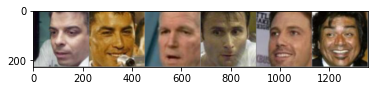

GroundTruth:  Felipe_Perez_Roque, Bernardo_Segura, Richard_Myers, Fabrice_Santoro, Ben_Affleck, George_Lopez


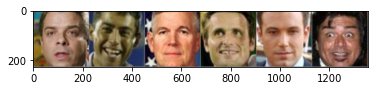

GroundTruth:  Felipe_Perez_Roque, Bernardo_Segura, Richard_Myers, Fabrice_Santoro, Ben_Affleck, George_Lopez


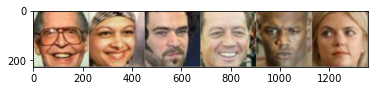

GroundTruth:  Milton_Berle, Maha_Habib, Romain_Duris, Bernard_Giraudeau, Clifford_Etienne, Melissa_Stark


In [8]:

Anchor,Positive,Negative=Obj.get_trainset(Percent=1,batchSize=6,numWorkers=2,Shuffle=False)
#Train_Set,Test_Set=Obj.getTrainSet_TestSet(ImagePerPerson=3, Percent=1,batchSize=1,numWorkers=4,Shuffle=False)
# functions to show an image
classes=os.listdir(Path)
classes=sorted(classes)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
AnchorIter = iter(Anchor)
images, labels = AnchorIter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join( classes[labels[j]] for j in range(len(labels))))


PositiveIter = iter(Positive)
images, labels = PositiveIter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join( classes[labels[j]] for j in range(len(labels))))

NegativeIter = iter(Negative)
images, labels = NegativeIter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join( classes[labels[j]] for j in range(len(labels))))


In [9]:
class KNN(nn.Module):
    def __init__(self, k = 3):
        super(KNN, self).__init__()
        self.K = k
        self.Vectors=[]
        self.Labels=[]
    def Reset(self):
        del self.Vectors
        del self.Labels
        self.Vectors=[]
        self.Labels=[]
    def Append(self,Vector,Label):
        self.Vectors.append(Vector)
        self.Labels.append(Label)
    def Dist(self,Obj1,Obj2):
        return (Obj1 - Obj2).pow(2).sum(1)
    
    def most_frequent(self,List): 
        occurence_count = Counter(List) 
        return occurence_count.most_common(1)[0][0]
    
    def getKNNLabel(self,Vector):
        Distances=[]
        for i in self.Vectors:
            Distances.append(torch.dist(Vector,i))
        Indices=np.argsort(Distances)
        Options=[]
        
        for i in range(self.K):
            Options.append(self.Labels[Indices[i]])
        return self.most_frequent(Options)

In [10]:
class TripletLoss(nn.Module):
    def __init__(self, Margin = 0.6):
        super(TripletLoss, self).__init__()
        self.Margin = Margin
        self.CheckGrad=False

    def forward(self,a, p, n) : 
        d = nn.PairwiseDistance()
        pos_dist = d(a, p)
        neg_dist = d(a, n)
        distance = pos_dist - neg_dist + self.Margin
        if torch.mean(torch.max(neg_dist, torch.zeros_like(neg_dist)))>torch.mean(torch.max(pos_dist+self.Margin, torch.zeros_like(pos_dist))):
            self.CheckGrad=False
        else:
            self.CheckGrad=True
        loss = torch.mean(torch.max(distance, torch.zeros_like(distance)))
        return loss

In [11]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_size=256):
        super(SiameseNet, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=(1,1), padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2), stride=(2,2)),

            nn.Conv2d(64, 128, 5, stride=(1,1), padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2,2), stride=(2,2)),

            nn.Conv2d(128, 256, 3, stride=(1,1), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d((2,2), stride=(2,2)),

            nn.Conv2d(256, 512, 3, stride=(1,1), padding=1),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm2d(512)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(512 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            #nn.BatchNorm2d(1024),
            nn.Linear(256, embedding_size),
        )

    def forward(self, X):
        X = self.cnn1(X)
        #print(X.shape)
        X = X.view(X.size()[0], -1)
        X = self.fc1(X)
        return X

In [12]:
"""import torchvision.models as models
class Resnet(nn.Module):
    def __init__(self, embedding_dim=128, pretrained = False):
        super(Resnet, self).__init__()
        self.embedding_dim = embedding_dim
        self.resnet18 = models.resnet18(pretrained=pretrained)
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, embedding_dim)
        # self.batch_norm = nn.BatchNorm1d(embedding_dim, momentum=0.01)
        self.init_weights()
    
    def init_weights(self):
        self.resnet18.fc.weight.data.normal_(0.0, 0.02)
        self.resnet18.fc.bias.data.fill_(0)
        
    def forward_train(self, Anchor, Positive, Negative):
        Anchor = self.resnet18(Anchor)
        Positive = self.resnet18(Positive)
        Negative = self.resnet18(Negative)
        

        return Anchor,Positive,Negative
    
    def forward_test(self, images):
        embed = self.resnet18(images)
        # embed = self.batch_norm(embed)
        return embed"""

'import torchvision.models as models\nclass Resnet(nn.Module):\n    def __init__(self, embedding_dim=128, pretrained = False):\n        super(Resnet, self).__init__()\n        self.embedding_dim = embedding_dim\n        self.resnet18 = models.resnet18(pretrained=pretrained)\n        in_features = self.resnet18.fc.in_features\n        self.resnet18.fc = nn.Linear(in_features, embedding_dim)\n        # self.batch_norm = nn.BatchNorm1d(embedding_dim, momentum=0.01)\n        self.init_weights()\n    \n    def init_weights(self):\n        self.resnet18.fc.weight.data.normal_(0.0, 0.02)\n        self.resnet18.fc.bias.data.fill_(0)\n        \n    def forward_train(self, Anchor, Positive, Negative):\n        Anchor = self.resnet18(Anchor)\n        Positive = self.resnet18(Positive)\n        Negative = self.resnet18(Negative)\n        \n\n        return Anchor,Positive,Negative\n    \n    def forward_test(self, images):\n        embed = self.resnet18(images)\n        # embed = self.batch_norm(e

In [13]:
"""import torchvision.models as models
class Resnet(nn.Module):
    def __init__(self, embedding_dim=128, pretrained = False):
        super(Resnet, self).__init__()
        self.embedding_dim = embedding_dim
        self.resnet50 = models.resnet50(pretrained=pretrained)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, embedding_dim)
        # self.batch_norm = nn.BatchNorm1d(embedding_dim, momentum=0.01)
        self.init_weights()
    
    def init_weights(self):
        self.resnet50.fc.weight.data.normal_(0.0, 0.02)
        self.resnet50.fc.bias.data.fill_(0)
        
    def forward_train(self, Anchor, Positive, Negative):
        Anchor = self.resnet50(Anchor)
        Positive = self.resnet50(Positive)
        Negative = self.resnet50(Negative)
        

        return Anchor,Positive,Negative
    
    def forward_test(self, images):
        embed = self.resnet50(images)
        # embed = self.batch_norm(embed)
        return embed"""

'import torchvision.models as models\nclass Resnet(nn.Module):\n    def __init__(self, embedding_dim=128, pretrained = False):\n        super(Resnet, self).__init__()\n        self.embedding_dim = embedding_dim\n        self.resnet50 = models.resnet50(pretrained=pretrained)\n        in_features = self.resnet50.fc.in_features\n        self.resnet50.fc = nn.Linear(in_features, embedding_dim)\n        # self.batch_norm = nn.BatchNorm1d(embedding_dim, momentum=0.01)\n        self.init_weights()\n    \n    def init_weights(self):\n        self.resnet50.fc.weight.data.normal_(0.0, 0.02)\n        self.resnet50.fc.bias.data.fill_(0)\n        \n    def forward_train(self, Anchor, Positive, Negative):\n        Anchor = self.resnet50(Anchor)\n        Positive = self.resnet50(Positive)\n        Negative = self.resnet50(Negative)\n        \n\n        return Anchor,Positive,Negative\n    \n    def forward_test(self, images):\n        embed = self.resnet50(images)\n        # embed = self.batch_norm(e

In [14]:
def Accuracy():
    MyNetwork.to("cpu")
    with torch.no_grad():
        
        KNNClassifier=KNN(3)
        Train_Set,Test_Set = Loader.getTrainSet_TestSet(batchSize=1)
        #print('Total Test Cases:',len(Test_Set))
        #Loading Training Data into KNN Classifier
        for i,data in enumerate(Train_Set):
            Vector,Label=data
            Vector=MyNetwork(Vector)
            KNNClassifier.Append(Vector,classes[Label[0]])

        Actual = []
        Predicted = []

        for i,data in enumerate(Test_Set):
            Vector,Label = data
            Vector = MyNetwork(Vector)
            Predicted.append(KNNClassifier.getKNNLabel(Vector))
            Actual.append(classes[Label[0]])

        Correct=0
        for i in range(len(Actual)):
            #print(Actual[i],'----->',Predicted[i])
            if Actual[i]==Predicted[i]:
                Correct+=1
        #print("Accuracy:",round(100*(Correct/len(Actual)),2 ),"%")
        Total=len(Actual)
        del Actual
        del Predicted
        del KNNClassifier
        del Train_Set
        del Test_Set
    MyNetwork.to(device)
    return round(100*(Correct/Total),2)

In [15]:
%%time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transformation = transforms.Compose(
    [transforms.CenterCrop(120),
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))
     ])

MyNetwork=SiameseNet()
LossFunction = TripletLoss()

optimizer = torch.optim.Adam(MyNetwork.parameters(), lr = 0.000001)
Loader = DataLoader(Path,transformation)
#MyNetwork
MyNetwork.to(device)
LossFunction.to(device)


CPU times: user 3.17 s, sys: 1.75 s, total: 4.92 s
Wall time: 8.81 s


TripletLoss()

In [16]:
%%time

Epochs=25
LossOverEpochs=[]
AccuracyOverEpochs=[]
for j in range(Epochs):  # loop over the dataset mult1iple times1

    running_loss = 0.0
    Loader.loadPairs()
    A,B,C=Loader.get_trainset(Percent=1,batchSize=16,numWorkers=1,Shuffle=False)
    for i,(Anchor,Positive,Negative) in enumerate(zip(A,B,C)):
        Anchor,x = Anchor
        Positive,y = Positive
        Negative,z = Negative

        Anchor = Anchor.to(device)
        Positive = Positive.to(device)
        Negative = Negative.to(device)
        optimizer.zero_grad()

        # forward + backward + optimize
        AnchorOutput  = MyNetwork(Anchor)
        PositiveOutput = MyNetwork(Positive)
        NegativeOutput = MyNetwork(Negative)
        loss = LossFunction(AnchorOutput,PositiveOutput,NegativeOutput)
        #if LossFunction.CheckGrad:
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        del Anchor
        del Positive
        del Negative
        torch.cuda.empty_cache()
    Loss=running_loss/len(A)
    LossOverEpochs.append(round(Loss,6))
    
    #if x=='1':
    AccuracyOverEpochs.append(Accuracy())
    print('Epoch#'+str(j+1).zfill(2)+'.',' Accuracy:',AccuracyOverEpochs[j],' Loss:',LossOverEpochs[j])
    x=input('1.To Save State & Continue 2.To Continue 3.To Exit:')
    if x=='1':
        torch.save(MyNetwork.state_dict(), "./TrainedNN_Epoch_"+str(j+1)+".pth")
    elif x=='3':
        break

Epoch#01.  Accuracy: 55.0  Loss: 0.348618
1.To Save State & Continue 2.To Continue 3.To Exit:1
Epoch#02.  Accuracy: 50.0  Loss: 0.19088
1.To Save State & Continue 2.To Continue 3.To Exit:2
Epoch#03.  Accuracy: 45.0  Loss: 0.154775
1.To Save State & Continue 2.To Continue 3.To Exit:2
Epoch#04.  Accuracy: 55.0  Loss: 0.102331
1.To Save State & Continue 2.To Continue 3.To Exit:2
Epoch#05.  Accuracy: 60.0  Loss: 0.093309
1.To Save State & Continue 2.To Continue 3.To Exit:1
Epoch#06.  Accuracy: 70.0  Loss: 0.073164
1.To Save State & Continue 2.To Continue 3.To Exit:1
Epoch#07.  Accuracy: 60.0  Loss: 0.068962
1.To Save State & Continue 2.To Continue 3.To Exit:3
CPU times: user 4min 21s, sys: 3min 40s, total: 8min 2s
Wall time: 13min 3s


27730